<a href="https://colab.research.google.com/github/geantrindade/ConvNet-Performance-Prediction/blob/master/notebooks/train_evaluate_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
# Can we use naive bayes as a regressor?
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut # There is also a LeaveOneOut class in sklearn.cross_validation (what's the difference?)
from sklearn.model_selection import train_test_split

# Load and split dataset

In [0]:
def load_split(dataset_path, test_ratio):
  # No meta-dataset teremos apenas 1 output (ex accuracy) 
  # ou múltiplos outputs? (multi-regressão?)
  df = pd.read_csv(dataset_path, header=None)
  X = df.iloc[:,:-1].values
  y = df.iloc[:,-1].values

  # Is it necessary to scale the data?
  min_max_scaler = preprocessing.MinMaxScaler()
  X = min_max_scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state=1)

  # I used LeaveOneOut only as a test, I guess we should use train_test_split
  # splitter = LeaveOneOut()
  # for train_indices, test_indices in splitter.split(X):
  #   X_train, y_train = X[train_indices], y[train_indices]
  #   X_test, y_test = X[test_indices], y[test_indices]
  
  return X_train, y_train, X_test, y_test

# Hyperparameters

### Logistic regression

In [0]:
lr_params = {'penalty' : 'l2',          # options: l1’, ‘l2’, ‘elasticnet’, ‘none’
             'dual' : True,             # Prefer dual=False when n_samples > n_features (only with l2 and liblinear)
             'tol' : 1e-4,              # Tolerance for stopping criteria
             'C' : 1.0,                 # Smaller values -> Stronger regularization
             'fit_intercept' : True,
             'intercept_scaling' : 1,
             'class_weight' : None,
             'random_state' : 1,
             'solver' : 'liblinear',    # ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
             'max_iter' : 100,
             'multi_class' : 'auto',    # ‘auto’, ‘ovr’, ‘multinomial’
             'verbose' : 0,
             'warm_start' : False}

### KNeighborsRegressor

In [0]:
knr_params = {'n_neighbors' : 5,
              'weights' : 'uniform',     # Weight function used in prediction
              'algorithm' : 'auto',      # Algorithm used to compute nearest neighbors {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
              'leaf_size' : 30,          # Leaf size passed to ball_tree or kd_tree
              'p' : 2,                   # Power parameter for Minkowski metric
              'metric' : 'minkowski',
              'metric_params' : None,
              'n_jobs' : None}           # Number of parallel jobs to run for neighbors search

### DecisionTreeRegressor

In [0]:
dtr_params = {'criterion' : 'mse',                 # {“mse”, “friedman_mse”, “mae”}
              'splitter' : 'best',                 # {“best”, “random”}
              'max_depth' : None,
              'min_samples_split' : 2,                   # Min number of samples to split a node
              'min_samples_leaf' : 1,              # The minimum number of samples required to be at a leaf node
              'min_weight_fraction_leaf' : 0.0,
              'max_features' : None,               # int, float or {“auto”, “sqrt”, “log2”}
              'random_state' : None,
              'max_leaf_nodes' : None,             # Grow a tree with max_leaf_nodes in best-first fashion
              'min_impurity_decrease' : 0.0,
              'min_impurity_split' : 1e-7,         # Threshold for early stopping in tree growth
              'presort' : 'deprecated',
              'ccp_alpha' : 0.0}                   # Complexity parameter used for Minimal Cost-Complexity Pruning

### SVR (SupportVectorRegressor)

In [0]:
svr_params = {'kernel' : 'rbf',      # {'linear','poly','rbf','sigmoid','precomputed'}
              'degree' : 3,          # only used for 'poly' kernel
              'gamma' : 'scale',     # used for 'poly','rbf' and 'sigmoid' {'scale', 'auto'}
              'coef0' : 0.0,         #Independent term in kernel function (‘poly’ and ‘sigmoid’)
              'tol' : 1e-3,
              'C' : 1.0,             # Regularization parameter
              'epsilon' : 0.1,
              'shrinking' : True,
              'verbose' : False,
              'max_iter' : -1}

### MLPRegressor

In [0]:
mlpr_params = {'hidden_layer_sizes' : (100,),
               'activation' : 'relu',            # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
               'solver' : 'adam',                # {‘lbfgs’, ‘sgd’, ‘adam’}
               'alpha' : 0.0001,                 # L2 regularization param
               'batch_size' : 'auto',            # ex: batch_size=min(200, n_samples)
               'learning_rate' : 'constant',     # {‘constant’, ‘invscaling’, ‘adaptive’}
               'learning_rate_init' : 0.001,
               'power_t' : 0.5,                  # The exponent for inverse scaling learning rate
               'max_iter' : 500,
               'shuffle' : True,
               'random_state' : None,
               'tol' : 1e-4,
               'verbose' : False,
               'warm_start' : False,
               'momentum' : 0.9,
               'nesterovs_momentum' : True,
               'early_stopping' : False,
               'validation_fraction' : 0.1,      # Only used if early_stopping is True
               'beta_1' : 0.9,                   # Exponential decay rate for estimates of first moment vector in adam
               'beta_2' : 0.999,                 # Exponential decay rate for estimates of second moment vector in adam
               'epsilon' : 1e-8,                 # Value for numerical stability in adam.
               'n_iter_no_change' : 10,
               'max_fun' : 15000}

### RandomForestRegressor

In [0]:
rfr_params = {'n_estimators' : 10,                # Number of trees in the forest
              'criterion' : 'mse',                # Function to measure the quality of a split
              'max_depth' : None,                 # Max depth of the tree
              'min_samples_split' : 2,            # Min number of samples to split a node
              'min_samples_leaf' : 1,             # Min nb of sambles to be at leaf node
              'min_weight_fraction_leaf' : 0.0,
              'max_features' : 'auto',
              'max_leaf_nodes' : None,
              'min_impurity_decrease' : 0.0,
              'min_impurity_split' : 1e-7,
              'bootstrap' : True,
              'oob_score' : False,
              'n_jobs' : None,                  # Nb of jobs to run in parallel (fit, preditc, ...)
              'random_state' : None,
              'verbose' : 0,
              'warm_start' : False,
              'ccp_alpha' : 0.0,                # Complexity parameter used for Minimal Cost-Complexity Pruning
              'max_samples' : None}

### XGBRegressor

In [0]:
xgbr_params = {'base_score': 0.5,             # Initial prediction for all instances (global bias)
               'booster': 'gbtree',           # {'gbtree', 'gblinear', 'dart'}
               'colsample_bylevel': 1,        # Subsample ratio of columns for each level
               'colsample_bynode': 1,         # Subsample ratio for columns for each split
               'colsample_bytree': 1,         # Subsample ratio of columns when constructing each tree
               'gamma': 0,                    # Minimum loss reduction to make a further partition
               'importance_type': 'gain',     # {'gain', 'weight', 'cover', 'total_gain', 'total_cover'}
               'learning_rate': 0.1,
               'max_delta_step': 0,           # Max step allowed to each tree's weight estimation to be
               'max_depth': 3,
               'min_child_weight': 1,
               'missing': None,
               'n_estimators': 100,
               'n_jobs': 1,
               'nthread': None,
               'objective': 'reg:squarederror',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'scale_pos_weight': 1,
               'seed': None,
               'silent': None,
               'subsample': 1,
               'verbosity': 1}

# Save results

In [0]:
def summarizeResults(MAE, MSE, R2, params, model_type):

  results = open('modelsResults.txt', 'a')
  results.write('\n\n' + model_type)
  results.write('\nParameters:')

  for key,value in params.items():
    results.write('\n{} = {}'.format(key,value))

  results.write('\n\nResults:')
  results.write('\nMAE = {}'.format(MAE))
  results.write('\nMSE = {}'.format(MSE))
  results.write('\nR2 = {}'.format(R2))
  results.close()

# Train, fit, predict and save results

In [0]:
class MLRegModel():
  def __init__(self, X_train, y_train, X_test, y_test, regmodel, params):
    self.model = regmodel(**params)
    self.model.fit(X_train,y_train)
    self.y_pred = self.model.predict(X_test)
    self.MAE = mean_absolute_error(y_test, self.y_pred)
    self.MSE = MSE = mean_squared_error(y_test, self.y_pred)
    self.R2 = r2_score(y_test, self.y_pred)

  def get_save_results(self):
    summarizeResults(self.MAE, self.MSE, self.R2, self.model.get_params(), type(self.model).__name__)
    print('MAE: {} \nMSE: {} \nR2: {}'.format(self.MAE, self.MSE, self.R2))

# Maybe it's better creating a class instead of a function??
#def train_fit(X_train, y_train, X_test, y_test, regmodel, params):
#  model = regmodel(**params)
#  model.fit(X_train, y_train)
#  y_pred = model.predict(X_test)
#
#  MAE = mean_absolute_error(y_test, y_pred)
#  MSE = mean_squared_error(y_test, y_pred)
#  R2 = r2_score(y_test, y_pred)
#  summarizeResults(MAE, MSE, R2, model.get_params(), type(model).__name__)
#  print('MAE: {} \nMSE: {} \nR2: {}'.format(MAE, MSE, R2))

# Example

### Building a fictitious dataset

In [0]:
df = pd.DataFrame({1:list(range(50)),2:np.multiply(list(range(50)),2).tolist()})
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)

### Creating models considering the hyperparameters defined above

In [0]:
LogiReg = MLRegModel(X_train, y_train, X_test, y_test, LogisticRegression, lr_params)
KNReg = MLRegModel(X_train, y_train, X_test, y_test, KNeighborsRegressor, knr_params)
DTReg = MLRegModel(X_train, y_train, X_test, y_test, DecisionTreeRegressor, dtr_params)
SVReg = MLRegModel(X_train, y_train, X_test, y_test, SVR, svr_params)
MLayerReg = MLRegModel(X_train, y_train, X_test, y_test, MLPRegressor, mlpr_params)
RFReg = MLRegModel(X_train, y_train, X_test, y_test, RandomForestRegressor, rfr_params)
XGBReg = MLRegModel(X_train, y_train, X_test, y_test, XGBRegressor, xgbr_params)

models = [LogiReg, KNReg, DTReg, SVReg, MLayerReg, RFReg, XGBReg]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Plotting bar chart to compare the results

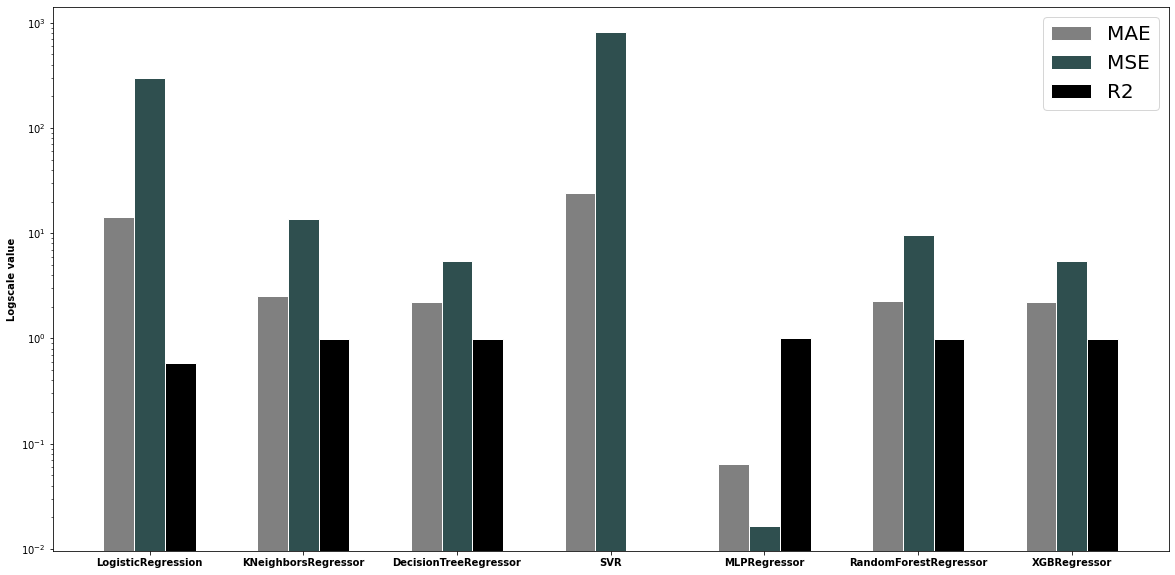

In [0]:
barWidth = 0.2

bars1 = [regmodel.MAE for regmodel in models]
bars2 = [regmodel.MSE for regmodel in models]
bars3 = [regmodel.R2 for regmodel in models]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(20,10))

plt.bar(r1, bars1, color = 'grey', width = barWidth, edgecolor = 'white', label = 'MAE')
plt.bar(r2, bars2, color = 'darkslategrey', width = barWidth, edgecolor = 'white', label = 'MSE')
plt.bar(r3, bars3, color = 'black', width = barWidth, edgecolor = 'white', label = 'R2')

plt.yscale('log')
plt.ylabel('Logscale value', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [type(regmodel.model).__name__ for regmodel in models], fontweight = 'bold')
plt.legend(prop = {'size': 20})

plt.show()